In [4]:
!pip install nilearn

In [5]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps
# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
#VOLUME_SLICES = 100
VOLUME_SLICES = 5
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128

In [7]:
TRAIN_DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

## Measure the domain shift between modalities

In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA

Maximum Mean Discrepancy (MMD) value: 0.14779521498545306


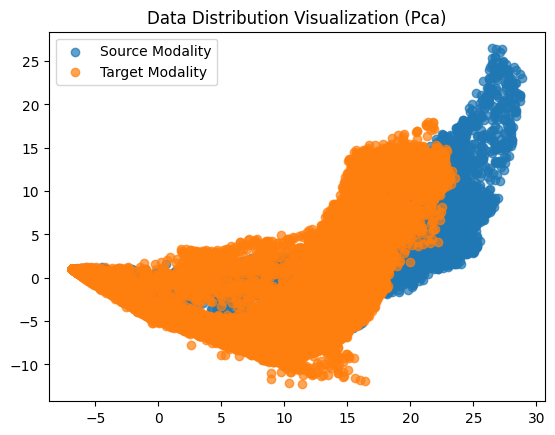

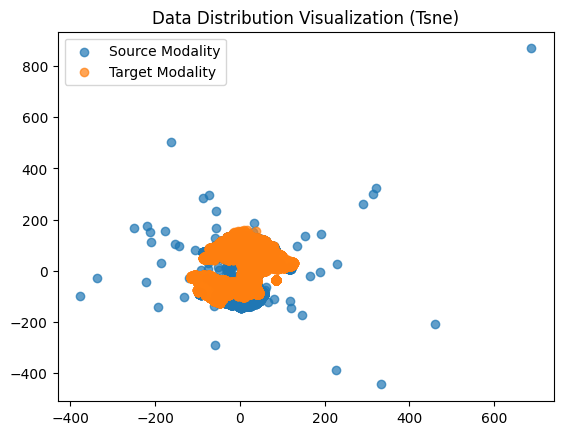

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import rbf_kernel
from sklearn import preprocessing

import SimpleITK as sitk
from scipy.stats import ttest_ind

def maximum_mean_discrepancy(X, Y, kernel='rbf', gamma=None, batch_size=1000):
    """
    Compute the Maximum Mean Discrepancy (MMD) between two sets of samples.

    Parameters:
    - X, Y: numpy arrays of shape (n_samples, n_features) representing the two sets of samples.
    - kernel: kernel function to be used ('rbf' for Radial basis function, 'linear', etc.).
    - gamma: parameter for the 'rbf' kernel (ignored for other kernels).
    - batch_size: batch size for batch-wise computation of kernel matrices.

    Returns:
    - mmd: Maximum Mean Discrepancy between the two sets of samples.
    """
    n = X.shape[0]
    m = Y.shape[0]

    mmd = 0.0

    for i in range(0, n, batch_size):
        X_batch = X[i:i + batch_size, :]
        for j in range(0, m, batch_size):
            Y_batch = Y[j:j + batch_size, :]

            if kernel == 'rbf':
                if gamma is None:
                    gamma = 1.0 / X.shape[1]  # Default value for gamma
                K_XX = rbf_kernel(X_batch, X_batch, gamma=gamma)
                K_YY = rbf_kernel(Y_batch, Y_batch, gamma=gamma)
                K_XY = rbf_kernel(X_batch, Y_batch, gamma=gamma)
            elif kernel == 'linear':
                K_XX = np.dot(X_batch, X_batch.T)
                K_YY = np.dot(Y_batch, Y_batch.T)
                K_XY = np.dot(X_batch, Y_batch.T)
            else:
                raise ValueError(f"Unsupported kernel: {kernel}")

            mmd += (np.sum(K_XX) / (n * (n - 1)) + np.sum(K_YY) / (m * (m - 1)) - 2 * np.sum(K_XY) / (n * m))

    return mmd


def visualize_distribution(X, Y, method='pca'):
    """
    Visualize the data distribution using PCA or t-SNE.

    Parameters:
    - X, Y: numpy arrays of shape (n_samples, n_features) representing the two sets of samples.
    - method: visualization method ('pca' for Principal Component Analysis, 'tsne' for t-SNE).
    """
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError(f"Unsupported visualization method: {method}")

    # Combine the data for visualization
    combined_data = np.vstack([X, Y])
    reduced_data = reducer.fit_transform(combined_data)

    # Separate the data back into source and target
    X_reduced = reduced_data[:X.shape[0], :]
    Y_reduced = reduced_data[X.shape[0]:, :]

    # Plot the visualization
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], label='Source Modality', alpha=0.7)
    plt.scatter(Y_reduced[:, 0], Y_reduced[:, 1], label='Target Modality', alpha=0.7)
    plt.title(f'Data Distribution Visualization ({method.capitalize()})')
    plt.legend()
    plt.show()


# X and Y are assumed to be numpy arrays of shape (n_samples, n_features)
def load_modalities(patient_id, modality1_path, modality2_path):
    """
    Load data for two modalities of a patient.

    Parameters:
    - patient_id: Patient identifier.
    - modality1_path: Path to the data for modality 1.
    - modality2_path: Path to the data for modality 2.

    Returns:
    - X, Y: Numpy arrays representing the data for the two modalities.
    """
    # Load data for modality 1
    image_modality1 = sitk.ReadImage(modality1_path)
    array_modality1 = sitk.GetArrayFromImage(image_modality1)
    X = array_modality1.reshape((-1, array_modality1.shape[-1]))

    # Load data for modality 2
    image_modality2 = sitk.ReadImage(modality2_path)
    array_modality2 = sitk.GetArrayFromImage(image_modality2)
    Y = array_modality2.reshape((-1, array_modality2.shape[-1]))

    return X, Y

# Example usage:
patient_id = "BraTS20_Training_001"
modality1_path = f"/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii"
modality2_path = f"/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii"

# Load data for two modalities
X, Y = load_modalities(patient_id, modality1_path, modality2_path)

np.random.seed(42)

# Normalize the data for better visualization (optional)
X = preprocessing.StandardScaler().fit_transform(X)
Y = preprocessing.StandardScaler().fit_transform(Y)

# Compute MMD
mmd_value = maximum_mean_discrepancy(X, Y, kernel='rbf', gamma=0.1)
print(f"Maximum Mean Discrepancy (MMD) value: {mmd_value}")

# Visualize data distribution using PCA
visualize_distribution(X, Y, method='pca')

# Visualize data distribution using t-SNE
visualize_distribution(X, Y, method='tsne')
